In [1]:
import pandas as pd
import numpy as np

from typing import List, Set

In [2]:
cognate = pd.read_csv("Grollemund_Data_Cognate.csv", index_col=0)
phonetic = pd.read_csv("Grollemund_Data_Phoneme.csv", index_col=0)
features = pd.read_csv("Chomsky_Halle_Features.csv", index_col=0)

clade_file = open('Clades.txt', 'r').readlines()
clades = {i.split(',')[0] : [j.strip() for j in i.split(',')[1:]] for i in clade_file}
    
all_phonemes = list(features.columns)[0:]

feature_matrix = pd.DataFrame(0, index=all_phonemes, columns=all_phonemes)

for phoneme1 in all_phonemes:
    for phoneme2 in all_phonemes:
        for (f, g) in zip(features.loc[:,phoneme1], features.loc[:,phoneme2]):
            if(not pd.isnull(f) and not pd.isnull(g) and f != g):
                # basically gets the Manhattan distance between two feature vectors
                feature_matrix.loc[phoneme1, phoneme2] += 1

feature_matrix

,m,p,mp,pʰ,mpʰ,b,mb,ɓ,mɓ,ɸ,...,ɛ,ø,œ,o,ɔ,ə,ʌ,æ,a,ɑ
m,0,2,1,2,1,2,1,2,1,2,...,1,1,1,1,1,1,1,1,1,1
p,2,0,1,1,2,1,2,2,3,1,...,1,1,1,1,1,1,1,1,1,1
mp,1,1,0,2,1,2,1,3,2,1,...,1,1,1,1,1,1,1,1,1,1
pʰ,2,1,2,0,1,2,3,3,4,1,...,1,1,1,1,1,1,1,1,1,1
mpʰ,1,2,1,1,0,3,2,4,3,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ə,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,1
ʌ,1,1,1,1,1,1,1,1,1,1,...,1,3,2,2,1,0,0,2,1,2
æ,1,1,1,1,1,1,1,1,1,1,...,1,2,1,3,2,0,2,0,1,2
a,1,1,1,1,1,1,1,1,1,1,...,2,3,2,2,1,0,1,1,0,1


In [7]:
import time
from scipy.spatial.distance import pdist

class CognateDistance:
    '''
    Gets distance between two cognate labels.


    Parameters
    ----------
    difference_cost
    '''
        
    def __init__(self, difference_cost: float = 1.):
        self._difference_cost = difference_cost
    
    def __call__(self, source: str, target: str) -> float:
        if (source == '?' or target == '?'): # if there's no data, assume maximum possible distance
            return 1.
        elif (source == target):
            return 0. 
        else:
            return self._difference_cost
    
    def common_words(self, lang1: str, lang2: str) -> int:
        common = 0
        
        for i, j in zip(cognate.loc[lang1], cognate.loc[lang2]):
            if(i != '?' and j !='?'):
                common += 1
                
        return common
    
    def distance_matrix(self, word: str) -> pd.core.frame.DataFrame:
        strings = np.array(list(cognate.loc[:,word]), dtype=object).reshape(-1,1)
        
        matrix = pdist(strings, lambda x, y: self(x[0], y[0]))

        return matrix
    
    def full_distance_matrix(self, phonemes: List[str]) -> np.array:
        full_matrix = np.zeros(int(len(cognate.index) ** 2 / 2 - len(cognate.index) / 2))
        for word in cognate.columns:
            full_matrix = np.add(full_matrix, self.distance_matrix(word))
            print(word)
        return full_matrix
    
class StringDistance:
    '''
    Gets the phonetic distance between strings.


    Parameters
    ----------
    insertion_cost
    deletion_cost
    cost_matrix
        an n by n matrix that contains a distance value between every phoneme
    '''
    
    def __init__(self, cost_matrix: pd.DataFrame, insertion_cost: float = 1.,
                 deletion_cost: float = 1.):
        self._insertion_cost = insertion_cost
        self._deletion_cost = deletion_cost
        # the dataframe looks nicer, but using a dictionary is several times faster in the actual function
        self.cost_matrix = cost_matrix.to_dict()

    def __call__(self, source: str, target: str) -> float:
        """
        Returns the distance between two strings.

        Parameters
        ----------
        source
        target
        """
        return self._wagner_fischer(source, target)
    
    def string_to_phonemes(self, string: str, phonemes: List[str]) -> List[str]:
        """
        Returns the distance between two strings.

        Parameters
        ----------
        source
        target
        """
        ordered_phonemes = list(sorted(phonemes, key = len))
        # this gets a list where the longest multigraphs appears first
        ordered_phonemes.reverse() 
        
        '''
        The data is formatted so that the class prefix is separated by a hyphen. 
        This should get the main roots whether these are hyphens or not.
        '''
        
        stem = string.split('-')
        
        if(len(stem) > 1):
            string = stem[1]
        else:
            string = stem[0]
        
        phoneme_list = list()
        i = 0
        while(i < len(string)):
            for p in ordered_phonemes:
                if(len(string) - i >= len(p) and string[i:i + len(p)] == p):
                    phoneme_list.append(p)
                    i += len(p)
                    break
                #if any character isn't part of the list of phonemes, ignore it
                elif(i < len(string) and string[i] not in phonemes):
                    i += 1
                    break
        return phoneme_list

    def _wagner_fischer(self, source: List[str], target: List[str]) -> float:
        '''
        Gets the Wagner–Fischer distance between two lists that represent strings.
        Based on the implementation found here:    
        https://www.codeproject.com/Articles/5342019/An-Optimal-Wagner-Fischer-Algorithm-For-Approximat
        
        Parameters
        ----------
        source
        target
        
        '''
        n, m = len(source), len(target)
        """
        Returns a distance of zero if source and target are equal.
        If only one string is present, the distance is equal to the length times the insertion cost
        per 
        """
        if source == target: 
            return 0
        elif source == []:
            return self._insertion_cost
        elif target == []:
            return self._insertion_cost
        
        e_d = np.arange(m, dtype=float)
        
        for i in range(1, n):
            e_i = np.concatenate(([i], np.zeros(m - 1, dtype=float)))
            
            for j in range(1, m):
            
                if source[i] == target[j]:
                    substitution_cost = 0.
                else:
                    substitution_cost = self.cost_matrix[source[i]][target[j]]
                    
                e_i[j] = min(e_d[j] + self._deletion_cost,
                             e_i[j - 1] + self._insertion_cost,
                             e_d[j - 1] + substitution_cost)
                
            e_d = np.array(e_i, copy=True)
                    
        # adjusts the distance by dividing by the length on the longest lexical item
        return e_d[len(e_d) - 1] / max(n, m)
    
    def distance_matrix(self, word: str, phonemes: List[str], square=False) -> pd.core.frame.DataFrame:
        strings = [self.string_to_phonemes(i, phonemes) for i in list(phonetic.loc[:,word])]
        strings = np.array(strings, dtype=object).reshape(-1,1)
        
        matrix = pdist(strings, lambda x, y: self(x[0], y[0]))
        
        if(square):
            return pd.DataFrame(squareform(matrix), columns=phonetic.index, index=phonetic.index).rename_axis(index=None)
        else:
            return matrix
        
    def full_distance_matrix(self, phonemes: List[str]) -> np.array:
        full_matrix = np.zeros(int(len(phonetic.index) ** 2 / 2 - len(phonetic.index) / 2))
        for word in phonetic.columns:
            start = time.time()
            full_matrix = np.add(full_matrix, self.distance_matrix(word, phonemes))
            end = time.time()
            print(word, "ellapsed: " + str(round(end - start, 2)) + " seconds") #this allows 
        return full_matrix

In [ ]:
phoneticdist = StringDistance(feature_matrix, 1., 1.)

# note: running the phonetic_matrix takes a few minutes
phonetic_matrix = phoneticdist.full_distance_matrix(all_phonemes)

animal ellapsed: 2.81 seconds
arm ellapsed: 2.95 seconds
ashes ellapsed: 3.01 seconds
bark ellapsed: 4.82 seconds
bed ellapsed: 1.96 seconds
belly ellapsed: 3.01 seconds
big ellapsed: 3.14 seconds
bird ellapsed: 4.65 seconds
bite ellapsed: 4.37 seconds
blood ellapsed: 3.98 seconds
bone ellapsed: 3.71 seconds
breast ellapsed: 3.84 seconds
burn ellapsed: 3.86 seconds
child ellapsed: 1.34 seconds
cloud ellapsed: 3.54 seconds
come ellapsed: 2.63 seconds
count ellapsed: 2.2 seconds
die ellapsed: 2.42 seconds
dog ellapsed: 2.86 seconds
drink ellapsed: 2.6 seconds
ear ellapsed: 2.85 seconds
eat ellapsed: 2.11 seconds
egg ellapsed: 2.76 seconds
elephant ellapsed: 2.23 seconds
eye ellapsed: 2.49 seconds
face ellapsed: 1.74 seconds
fall ellapsed: 2.12 seconds
fat, oil ellapsed: 3.24 seconds
feather ellapsed: 3.26 seconds
fingernail ellapsed: 3.56 seconds
fire ellapsed: 2.76 seconds
fire-wood ellapsed: 1.85 seconds
fish ellapsed: 2.99 seconds
five ellapsed: 2.51 seconds
fly ellapsed: 5.24 seconds

In [9]:
cognatedist = CognateDistance()
cognate_matrix = cognatedist.full_distance_matrix(all_phonemes)

animal
arm
ashes
bark
bed
belly
big
bird
bite
blood
bone
breast
burn
child
cloud
come
count
die
dog
drink
ear
eat
egg
elephant
eye
face
fall
fat, oil
feather
fingernail
fire
fire-wood
fish
five
fly
four
give
goat
ground, soil
hair
head
hear
heart
horn
house
hunger
intestine
kill
knee
knife
know
leaf
leg
liver
louse
man
moon
mouth
name
navel
neck
night
nose
one
person
rain
road/path
root
salt
sand
see
send
shame
sing
skin
sky
sleep
smoke
snake
spear
steal
stone
sun
tail
ten
three
tongue
tooth
tree
two
urine
village
vomit
walk
war
water
wind
woman
dew
iron


In [10]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

class Tree:

    def __init__(self, matrix, index, method=str):
        self.matrix = matrix
        self.index = index.index
        self.method = method

    def __call__(self, draw=True, golden_clades=True, score=True):
        clust = linkage(np.nan_to_num(self.matrix), method=self.method)

        ax = plt.subplots(figsize=(30, 100))[1]
        
        if(golden_clades):
            labels = ["{}, ({})".format(i, ' '.join([c for c in clades if i in clades[c]])) 
                                                     for i in self.index]
        else:
             labels=[i for i in self.index]
       
        dendrogram(clust, color_threshold=85., orientation='left', labels=labels)

        if(draw):
            plt.show()

        if(score):
            tree = to_tree(clust)
            self.score_tree(tree)
            
    def search_for_clade(self, tree, name, clade):
        _max = []
        self.search_clade_recurs(tree, name, clade, _max)
        node = max(_max, key=lambda x:x[1])[0] # gets the node with the max depth
        return node.pre_order(lambda x: self.index[x.id])

    def search_clade_recurs(self, node, name, clade, _list, depth=0):
        if not node:
            return None

        if(sum(i in node.pre_order(lambda x: self.index[x.id]) for i in clade) >= len(clade) * ((len(clade) - 1) / len(clade))):
            _list.append((node, depth))
            if set(node.pre_order(lambda x: self.index[x.id])) != set(clades[name]):
                self.search_clade_recurs(node.left, name, clade, _list, depth + 1)
                self.search_clade_recurs(node.right, name, clade, _list, depth + 1)

        return None

    def score_tree(self, tree, weigh=True, print_clades=False):
        score = 0
        total = 0
        claded_langs = [i for l in clades.values() for i in l] # only includes languages that are placed within a clade
        for clade in clades:
            clades_in_node = self.search_for_clade(tree, clade, clades[clade])
            missing_langs = len([l for l in clades[clade] if l not in clades_in_node])
            spurious_langs = len([l for l in clades_in_node if l not in clades[clade] and l in claded_langs])
            clade_score = max(0, 1 - (min(1, spurious_langs / len(clades[clade])) + missing_langs / len(clades[clade])))
            if(weigh):
                score += clade_score * len(clades[clade])
            else:
                score += clade_score
            if(print_clades):
                print(clade + ": " + str(round(clade_score, 2)))

        if(weigh):
            print("Tree score: " + str(round(score / len(claded_langs), 2)))
        else:
            print("Tree score: " + str(round(score / len(clades.values()), 2)))

In [24]:
#PhoneticTree = Tree(feature_matrix, phonetic, 'ward')
#PhoneticTree()

TypeError: float() argument must be a string or a real number, not 'dict'

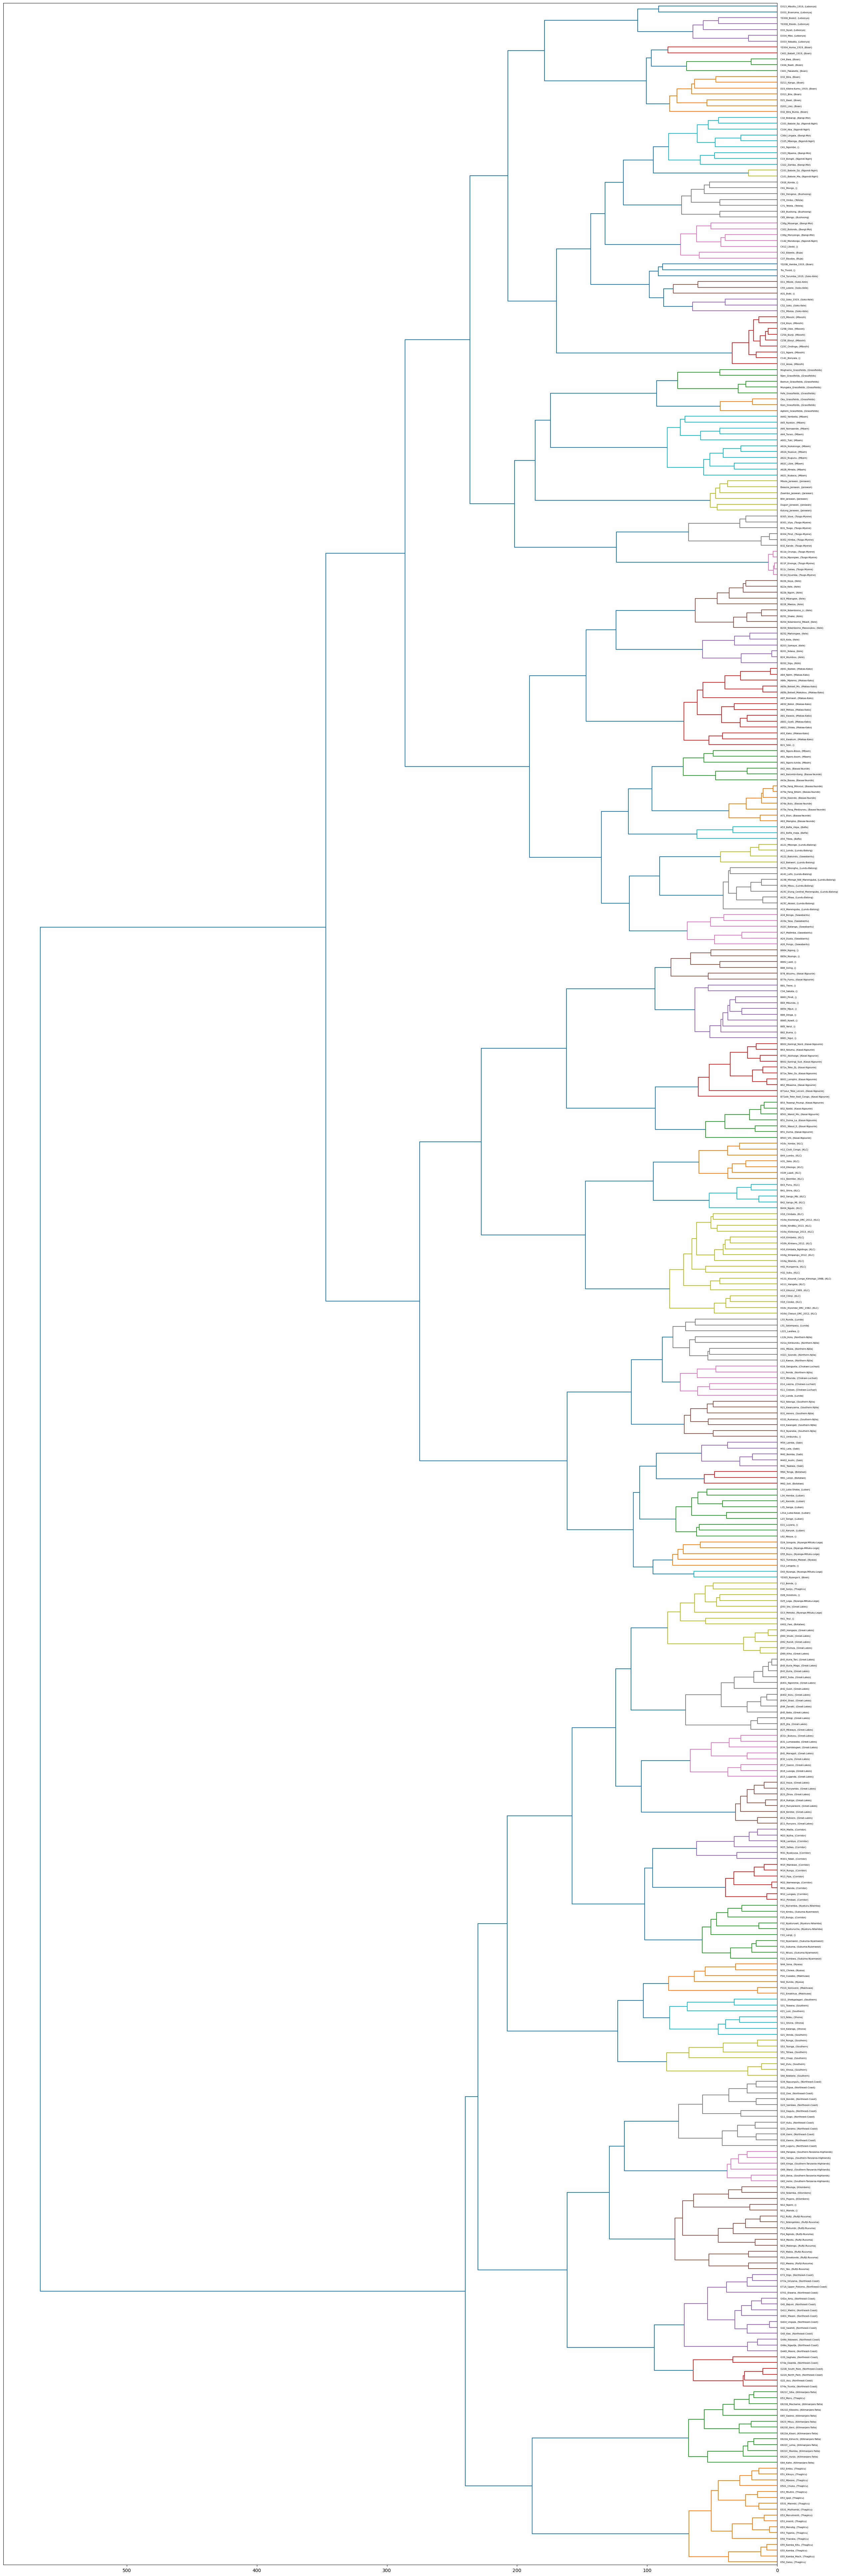

Tree score: 0.7


In [11]:
CognateTree = Tree(cognate_matrix, cognate, 'ward')
CognateTree()